# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing: Differencing

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how the plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [3]:
path = r'/Users/datcaodo/Documents/World Happiness Report 2024'

In [7]:
# Importing ".json" file for countries
country_geo = r'/Users/datcaodo/Documents/World Happiness Report 2024/03 Data/world-countries.json'

In [4]:
df = pd.read_csv(os.path.join(path, '/Users/datcaodo/Documents/World Happiness Report 2024', '03 Data', 'df.csv'))

In [5]:
df.shape

(2008, 13)

In [6]:
df.head()

,Unnamed: 0,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Social support category
0,0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258,Low Support
1,1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237,Low Support
2,2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275,Low Support
3,3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267,Low Support
4,4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268,Low Support


### 2. Subsetting, wrangling, and cleaning time-series data

In [8]:
# Creating subset with only 'year' and Life Ladder (median)

df_year = df.groupby("year").agg({'Life Ladder':['median']})

In [10]:
df_year.head(17)

,Life Ladder
,median
year,
2007,5.2140
2008,5.1910
2009,5.3285
2010,5.4560
2011,5.2040
2012,5.1875
2013,5.1580
2014,5.2970


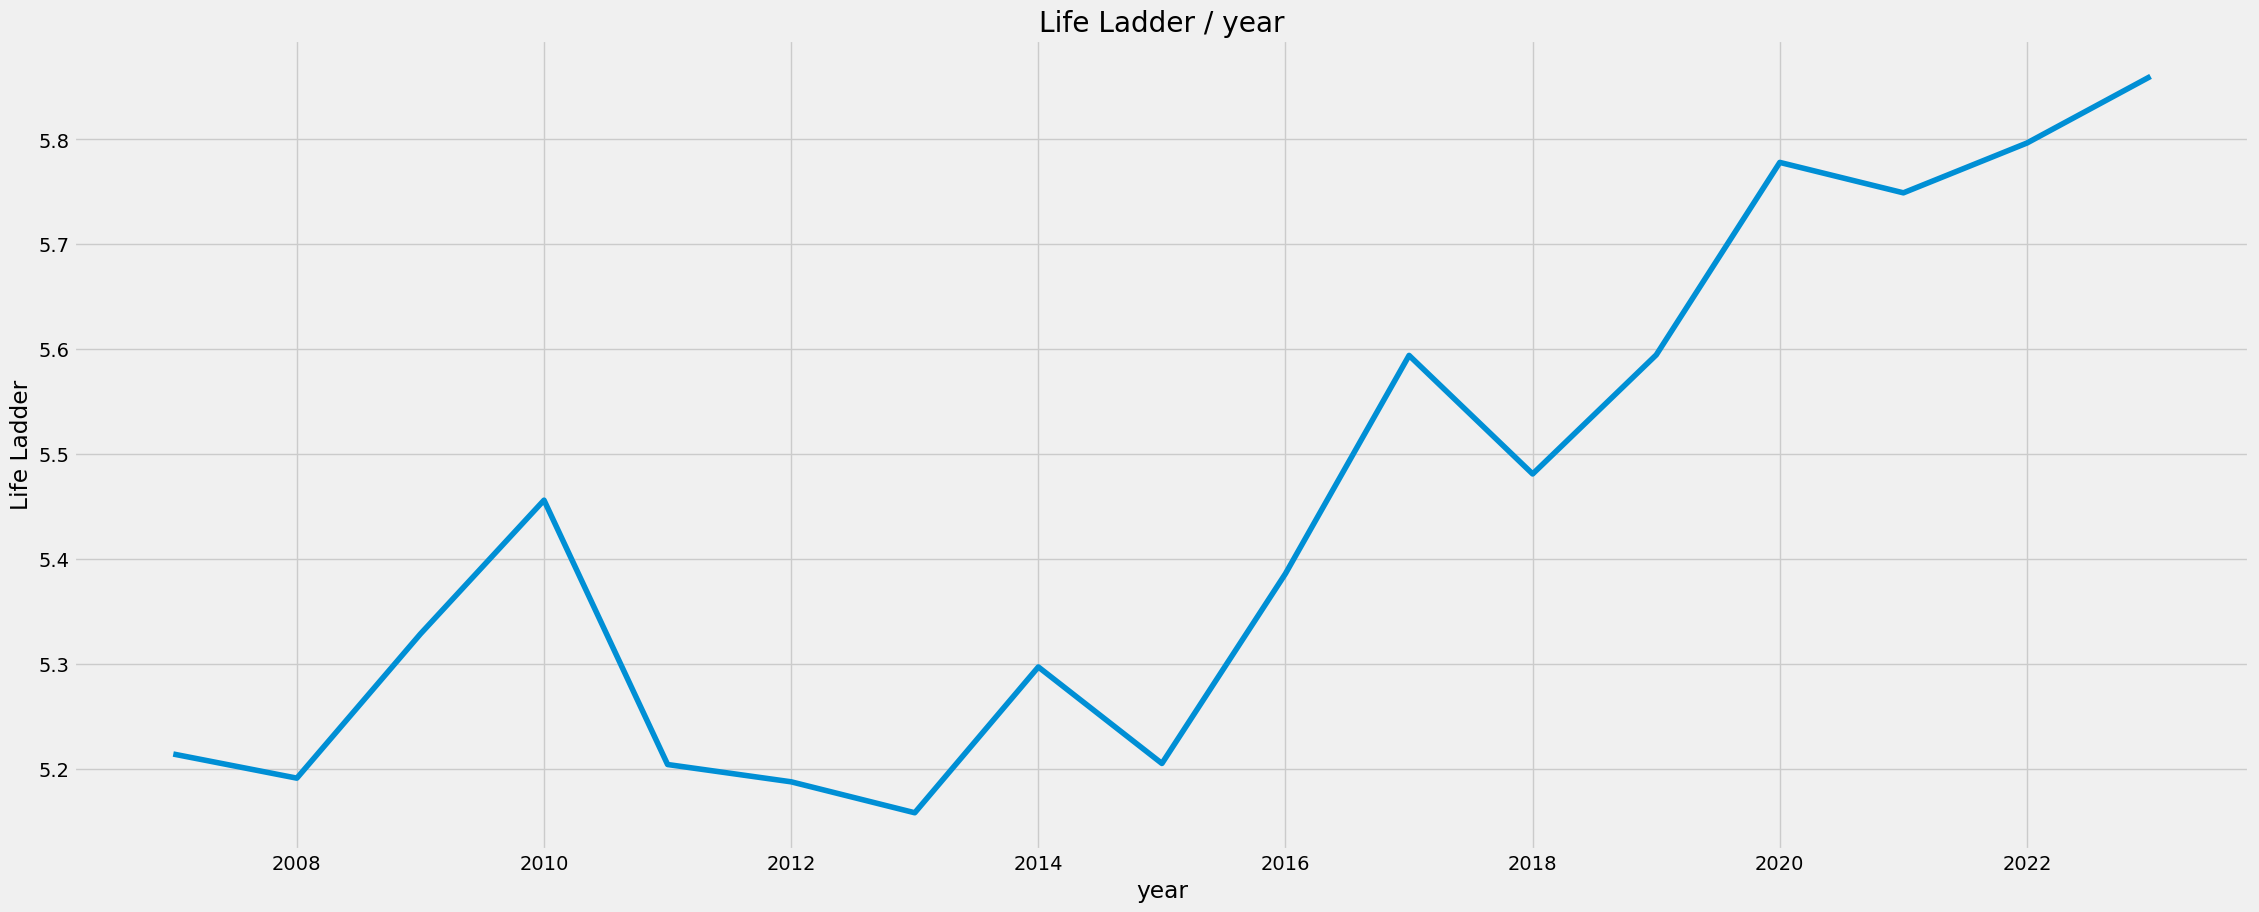

In [11]:
# Plot the new data set

plt.figure(figsize=(25,10), dpi=100)
plt.title("Life Ladder / year")
plt.xlabel("year")
plt.ylabel("Life Ladder")
plt.plot(df_year)

In [12]:
# Check for missing values (you shouldn't have any)

df_year.isnull().sum() 

Life Ladder  median    0
dtype: int64

In [13]:
# Check for duplicates

dups = df_year.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [14]:
df_year.index.freq = 'M'

In [16]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_year, model='additive' , period = 8)

In [17]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

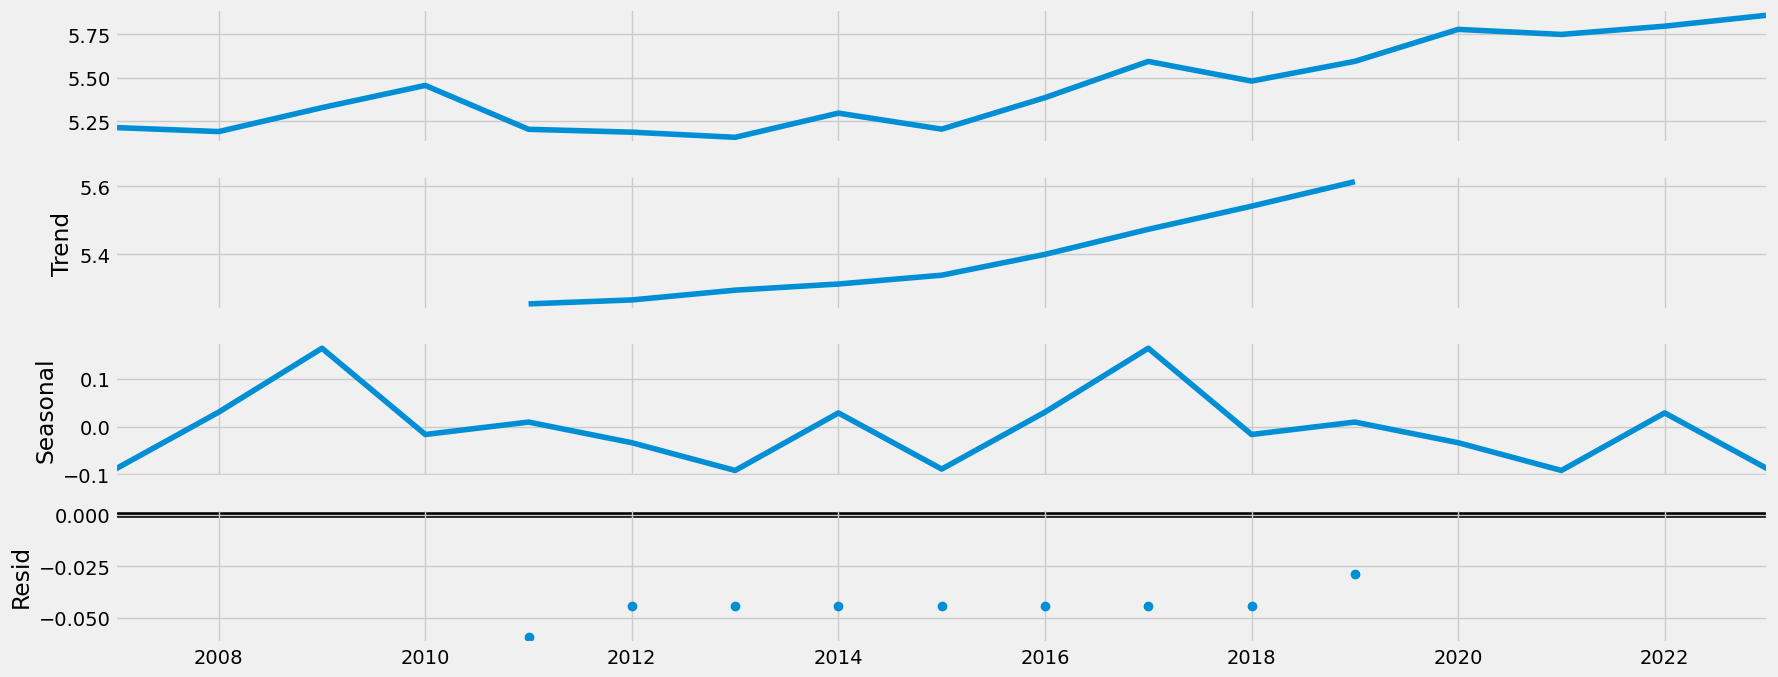

In [18]:
# Plot the separate components

decomposition.plot()
plt.show()

We can see that the trend line is rising with the time. Also, the overall Line on top shows a positive trend. 

### 4. Testing for stationarity

In [20]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why we need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_year['Life Ladder'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.053409
p-value                         0.953886
Number of Lags Used             6.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


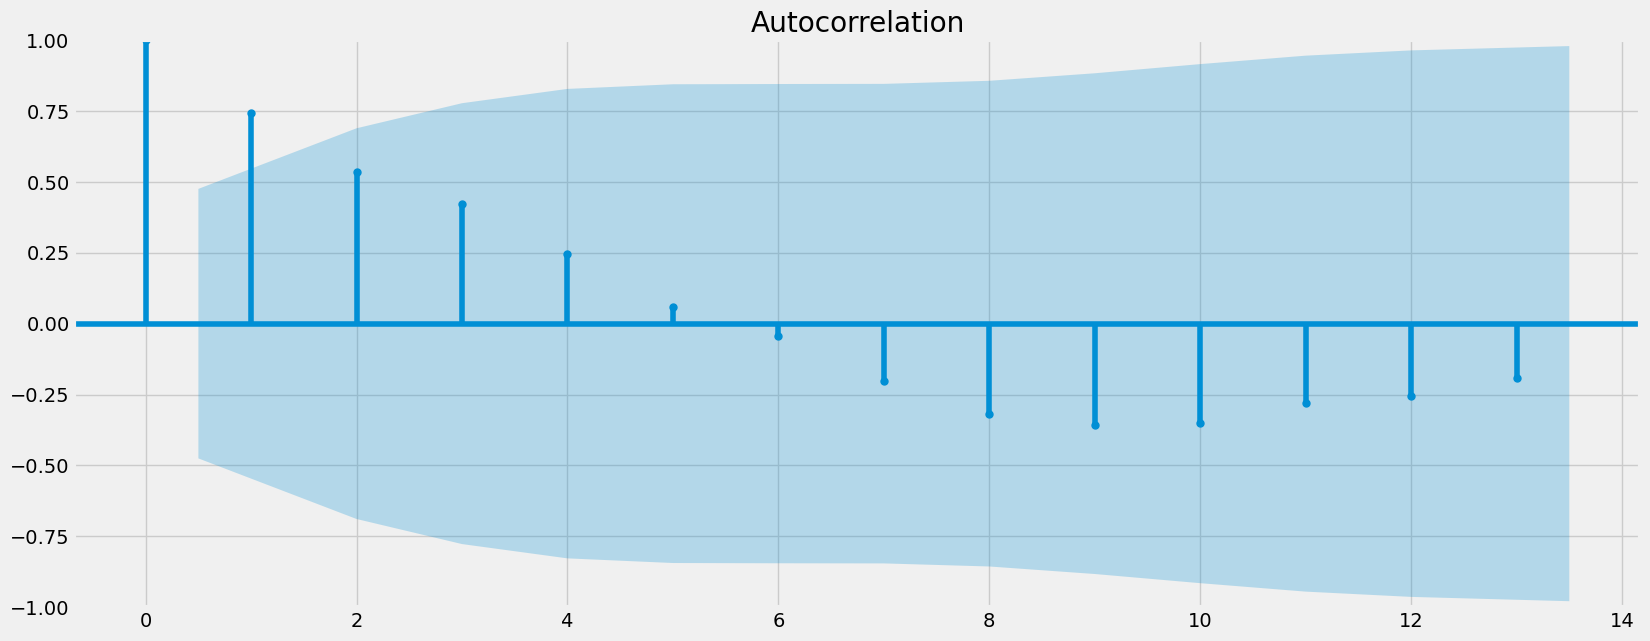

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, we import the autocorrelation and partial correlation plots

plot_acf(df_year)
plt.show()

#### p-value > 0.05 and Test statistic > Critival values 

=> cannot reject the null hypothesis and the data is not stationary.

### 5. Stationarizing: Differencing

In [23]:
data_diff = df_year - df_year.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [24]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [25]:
data_diff.head()

,Life Ladder
,median
year,
2008,-0.0230
2009,0.1375
2010,0.1275
2011,-0.2520
2012,-0.0165


In [26]:
data_diff.columns

MultiIndex([('Life Ladder', 'median')],
           )

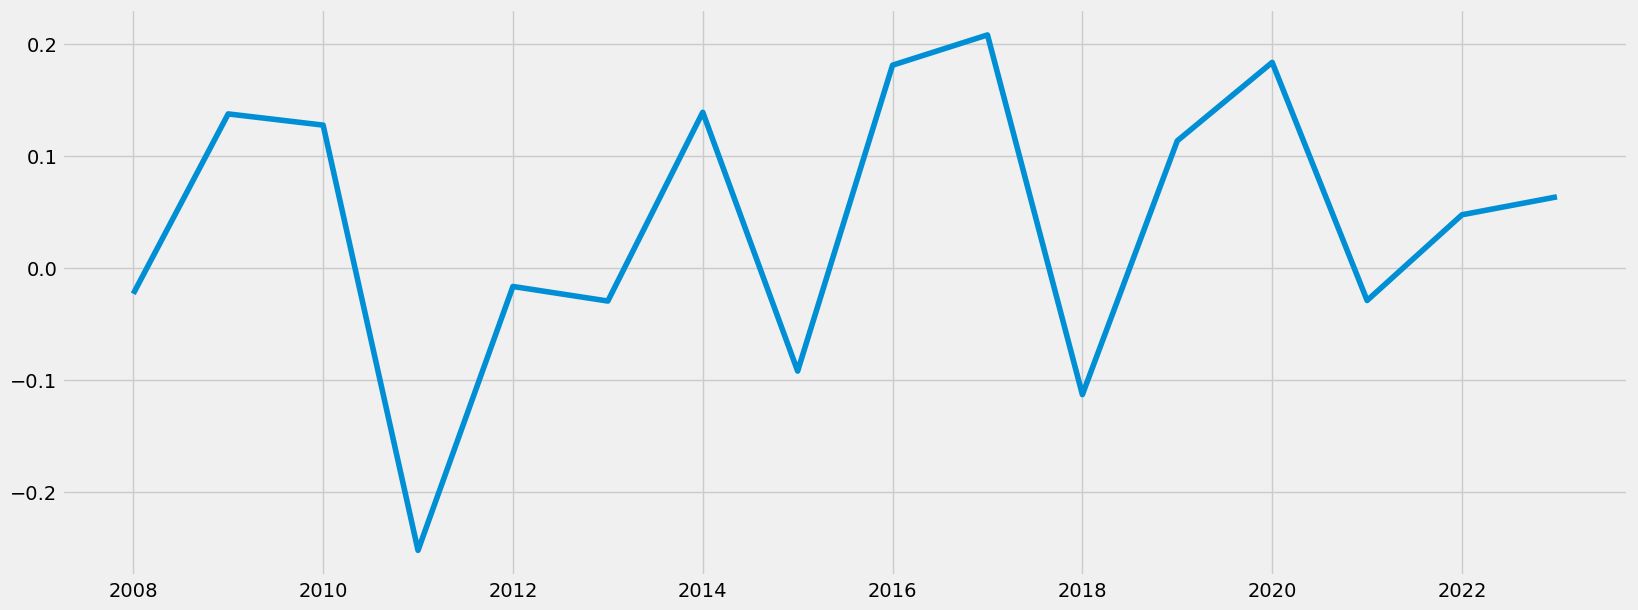

In [27]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(18,7), dpi=100)
plt.plot(data_diff)

In [28]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.776576
p-value                         0.000060
Number of Lags Used             5.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64


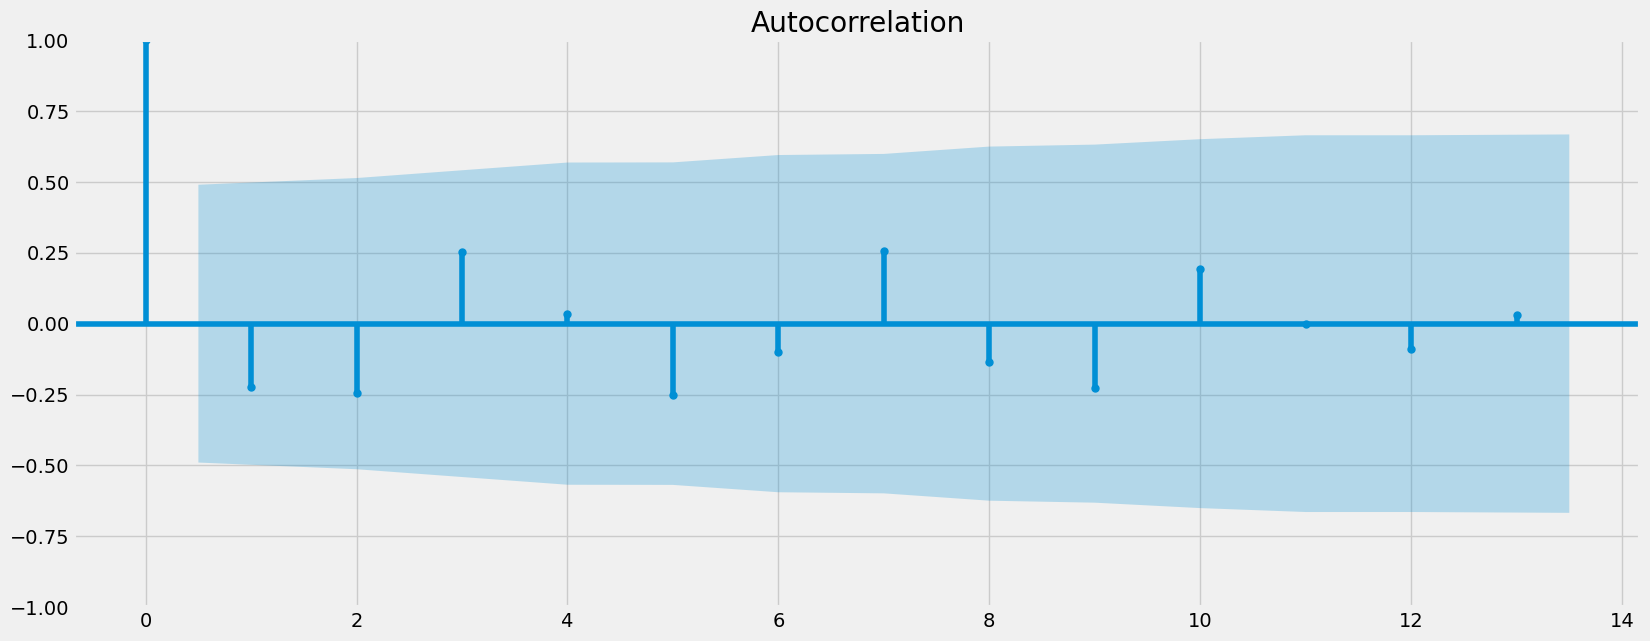

In [29]:
plot_acf(data_diff)
plt.show()

#### p-value < 0.05 and Test Statistic < Critival values

=> reject the null hypothesis and the data is stationary
